In [9]:
# importing dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
plt.style.use('seaborn')


# perform train-test-split - original csv file is imported again to start with a clean df
# import modules

# reading in data as df
df = pd.read_csv('Breast_Cancer.csv', delimiter=',')

# correcting typos
df = df.rename(columns={'T Stage ':'T Stage'})
df = df.rename(columns={'Reginol Node Positive': 'Regional Node Positive'})

# remapping target column
df.loc[:,'Status_encoded'] = df.loc[:,'Status'].map({'Alive':0, 'Dead':1})

# changing dtypes of columns as needed
dtypes_columns = {'Age' : 'int64',
'Race' : 'category',
'Marital Status' : 'category',
'T Stage' : 'category', 
'N Stage' : 'category',
'6th Stage' : 'category',
'differentiate' : 'category',
'Grade' : 'category',
'A Stage' : 'category', 
'Tumor Size' : 'int64',
'Estrogen Status' : 'category',
'Progesterone Status' : 'category',
'Regional Node Examined' : 'int64',
'Regional Node Positive' : 'int64',
'Survival Months' : 'int64',
'Status' : 'category',
'Status_encoded' : 'int64'}
df = df.astype(dtypes_columns)

# drop 'Grade' columns because the information is the same as in the 'differentiate' column 
df.drop('Grade', axis=1, inplace=True)

# creating target and features 
target = df.loc[:,'Status_encoded']
features = df.drop('Status', axis=1)
features = features.drop('Status_encoded', axis=1)

# train and test split
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            random_state=42,
                                                                            test_size=0.1)

C:\Users\bmerg\AppData\Local\Temp\ipykernel_16196\2422827942.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [10]:
display(features_train.shape)
display(features_test.shape)
display(target_train.shape)
display(target_test.shape)

(3621, 14)

(403, 14)

(3621,)

(403,)

In [34]:
# creating lists of categorical, ordinal and numerical columns
cat_cols = ['Race', 'Marital Status', 'Estrogen Status', 'Progesterone Status']
ord_cols = ['T Stage', 'N Stage', '6th Stage', 'differentiate', 'A Stage']
num_cols = [col for col in features_train.select_dtypes(include=["int64","float64"])]

In [ ]:
# choosing features for model
 selected_features = cat_cols + ord_cols + num_cols
# selecting only top 5 features extracted from feature_importance of DecisionTreeClassifier
# ['Age', 'Tumor Size', 'Survival Months', 'Regional Node Examined', 'Regional Node Positive']
# selected_features = num_cols

In [41]:


# gridsearch RandomForestClassifier

# setting up pipeline for OneHotEncoding and OrdinalEncoder
ohe_transformer = OneHotEncoder(drop='if_binary')
ord_transformer = OrdinalEncoder()
transformer = ColumnTransformer([#('cat_transformer', ohe_transformer, cat_cols), 
                                 #('ord_transformer', ord_transformer, ord_cols)
                                ], remainder='passthrough')

# creating model instance
model_rfc = RandomForestClassifier(class_weight='balanced', 
                                   random_state=42, 
                                   n_jobs=-1
                                  )

# creating baseline model pipeline
baseline_model = Pipeline([('preprocessing', transformer),
                           ('model', model_rfc)])

search_space_rfc = {'model__max_depth': np.geomspace(start=1, stop=250, num=10, dtype='int'),
                   'model__min_samples_leaf': np.geomspace(start=1, stop=40, num=10, dtype='int'),
                    'model__n_estimators': np.geomspace(start=25, stop=300, num=10, dtype='int')}

model_rfc = GridSearchCV(estimator=baseline_model,
                        param_grid=search_space_rfc,
                        scoring='f1',
                        cv=5,
                        n_jobs=-1)

# fitting model
model_rfc.fit(features_train[selected_features], target_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[])),
                                       ('model',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': array([  1,   1,   3,   6,  11,  21,  39,  73, 135, 250]),
                         'model__min_samples_leaf': array([ 1,  1,  2,  3,  5,  7, 11, 17, 26, 40]),
                         'model__n_estimators': array([ 25,  32,  43,  57,  75,  99, 131, 172, 227, 300])},
             scoring='f1')

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough', transformers=[])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=11,
                                        min_samples_leaf=3, n_estimators=172,
                                        n_jobs=-1, random_state=42))])
recall: 0.6571428571428571
precision: 0.7666666666666667
f1: 0.7076923076923077
accuracy: 0.9057071960297767


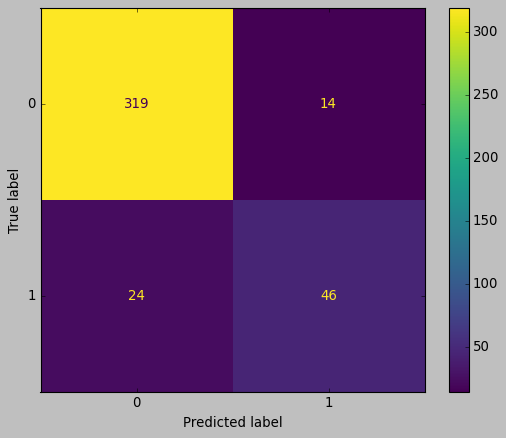

In [43]:
# predict and evaluate on test data
print(model_rfc.best_estimator_)

recall = recall_score(target_test, model_rfc.predict(features_test[selected_features]))
precision = precision_score(target_test, model_rfc.predict(features_test[selected_features]))
f1 = f1_score(target_test, model_rfc.predict(features_test[selected_features]))
accuracy = accuracy_score(target_test, model_rfc.predict(features_test[selected_features]))
print(f'recall: {recall}')
print(f'precision: {precision}')
print(f'f1: {f1}')
print(f'accuracy: {accuracy}')

# confusion matrix for predictions on test data
plt.style.use('classic')
test_pred = model_rfc.best_estimator_.predict(features_test[selected_features])
confusion_matrix(target_test, test_pred)
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model_rfc, features_test[selected_features], target_test);

In [ ]:

# Best score with all features
# Pipeline(steps=[('transformer',
#                  ColumnTransformer(remainder='passthrough', transformers=[])),
#                 ('model',
#                  RandomForestClassifier(class_weight='balanced', max_depth=25,
#                                         min_samples_leaf=3, n_estimators=209,
#                                         n_jobs=-1, random_state=42))])
# recall: 0.6571428571428571
# precision: 0.7796610169491526
# f1: 0.7131782945736433
# accuracy: 0.9081885856079405

# Best score with only top 5 features extracted from feature_importance of DecisionTreeClassifier
# ['Age', 'Tumor Size', 'Survival Months', 'Regional Node Examined', 'Regional Node Positive']

# Pipeline(steps=[('preprocessing',
#                  ColumnTransformer(remainder='passthrough', transformers=[])),
#                 ('model',
#                  RandomForestClassifier(class_weight='balanced', max_depth=1,
#                                         n_estimators=25, n_jobs=-1,
#                                         random_state=42))])
# recall: 0.6571428571428571
# precision: 0.8214285714285714
# f1: 0.73015873015873
# accuracy: 0.9156327543424317
